Построение модели на всем известных данных с титаника.  
Буду использовать только train данные, содержащие целевую.  
https://www.kaggle.com/c/titanic/data

# imports / data loads

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns

import utils.eda

Так как я не планирую размещать результаты на каггле, я не буду трогать тестовые данные без целевой и вообще предположу их отсутствие.  

In [2]:
df_base = pd.read_csv('data/train.csv', index_col='PassengerId')

# переименуем Survived в target для удобства
# и все наименования колонок приведем к единому регистру
df_base.columns = df_base.columns.str.lower()
df_base = df_base.rename(columns={'survived': 'target'})

In [3]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   target    891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   name      891 non-null    object 
 3   sex       891 non-null    object 
 4   age       714 non-null    float64
 5   sibsp     891 non-null    int64  
 6   parch     891 non-null    int64  
 7   ticket    891 non-null    object 
 8   fare      891 non-null    float64
 9   cabin     204 non-null    object 
 10  embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [4]:
df_base.head()

,target,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data splits

Сразу разделим данные на треин и тест. В тест разместим 25% данных, стратифицировав по целевой и по полу. Размер теста обусловлен общепринятыми практиками. Если бы наблюдений было больше, я бы рассмотрел уменьшение доли тестового сета.

Будем придерживаться практики минимизации утечек и далее продолжим работать только с тренировочными данными. В дальнейшем сравнение моделей будем проводить через кросс-валидацию.

In [5]:
from sklearn.model_selection import train_test_split

# Стратифицируем по целевой и по полу, так как мы заранее знаешь, что пол это сильный предиктор 
# и мы не ожидаем сильного смещения в распределении этой переменной в "реальных" данных
X_train, X_test, y_train, y_test = train_test_split(df_base.drop(columns='target'),
                                                    df_base['target'], 
                                                    test_size=0.25, 
                                                    random_state=42,
                                                    stratify=df_base[['target', 'sex']])

# Для удобства EDA склеим в датафреймы (с памятью проблем у нас тут нет)
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

utils.eda.make_splits_info(df_train, df_test)

,size,mean target
train,668,0.383234
test,223,0.385650


In [6]:
# Количество уникальных, для определения готовых категориальных переменных
df_train.nunique()

pclass        3
name        668
sex           2
age          84
sibsp         7
parch         6
ticket      537
fare        228
cabin       120
embarked      3
target        2
dtype: int64

# Plotting

Посмотрим на распределения переменных.
Разделим их по целевой и по полу

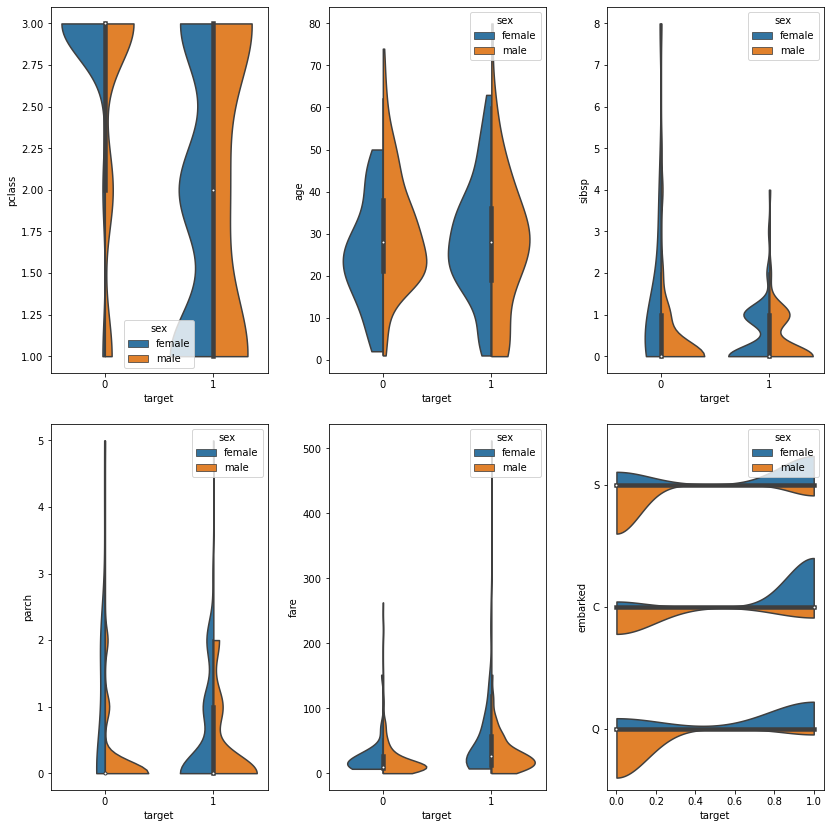

In [7]:
columns_to_plot = list(X_train.select_dtypes('number').columns) + ['embarked']

fig, axes = plt.subplots(2, 3, figsize=(12,12))
fig.tight_layout(pad=3.0)
for ax, variable in zip(axes.reshape(-1), columns_to_plot):
    sns.violinplot(y=variable, 
                   x='target', 
                   hue='sex', 
                   split=True, 
                   data=df_train, 
                   ax=ax, 
                   cut=0)
    
# тут по оси Х разбиение на целевую и скрипки разделены по полу

В случае не выживших пассажиров, многие переменные по разному распределены в зависимости от пола. Среди выживших больше сходств.

Ещё посмотрим графики по бинам и средней целевой в них

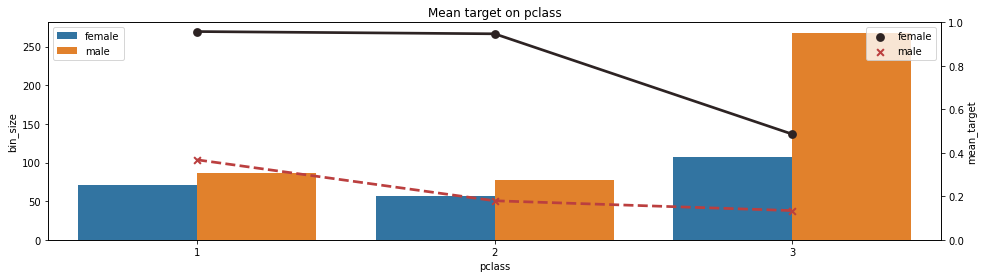

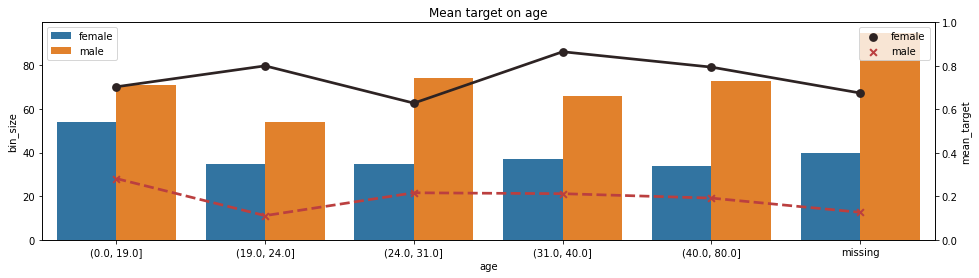

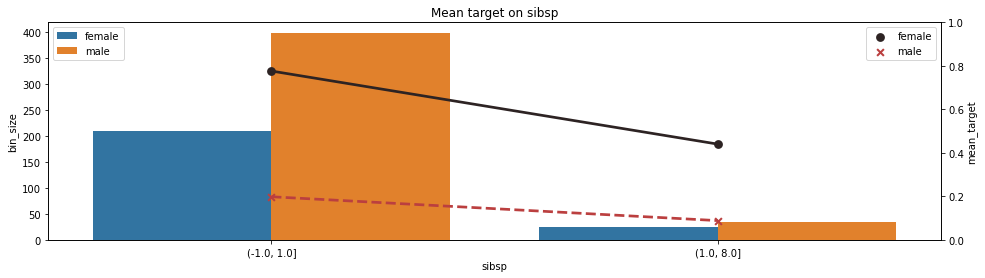

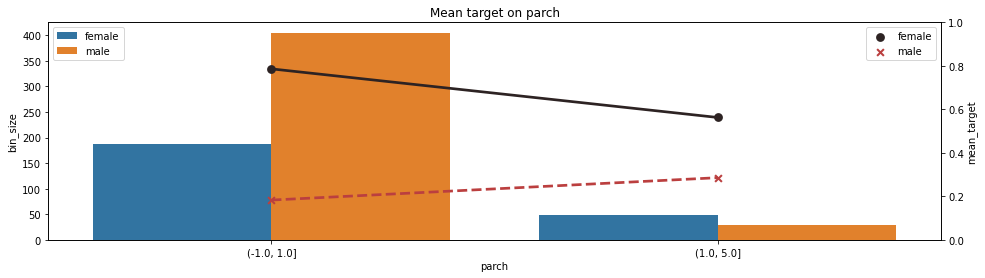

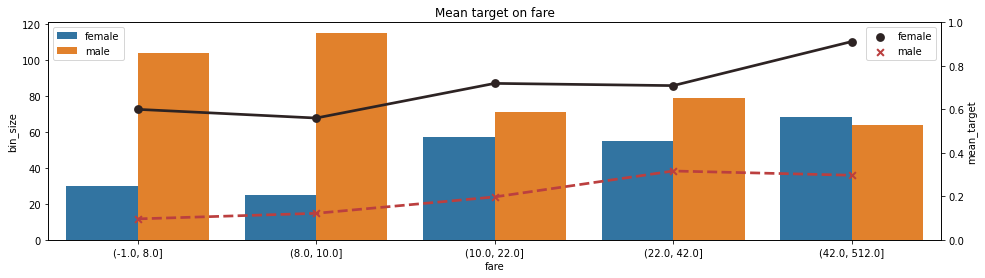

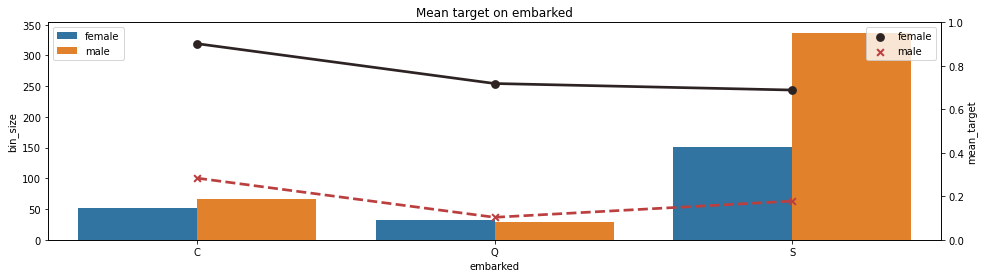

In [8]:
# эту функцию я писал когда то давно и эта версия неидеальна, но тут подойдет

for variable in columns_to_plot:
    utils.eda.plot_target_bins(df_train, variable, 'target')

# String feature generation

In [9]:
df_train.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,target
PassengerId,,,,,,,,,,,
134,2,"Weisz, Mrs. Leopold (Mathilde Francoise Pede)",female,29.0,1,0,228414,26.0000,NaN,S,1
151,2,"Bateman, Rev. Robert James",male,51.0,0,0,S.O.P. 1166,12.5250,NaN,S,0
112,3,"Zabour, Miss. Hileni",female,14.5,1,0,2665,14.4542,NaN,C,0
629,3,"Bostandyeff, Mr. Guentcho",male,26.0,0,0,349224,7.8958,NaN,S,0
649,3,"Willey, Mr. Edward",male,NaN,0,0,S.O./P.P. 751,7.5500,NaN,S,0


## Name transformations

Я выполню простые операции
* Посчитаем количество слов
* Добавим флаги титула. mr, miss ...
* Посчитаем длину и количество слов
* Самое длинное имя
* Топ самых популярных имен

In [10]:
def create_features_from_name(df_or):
    # just in case, since we have no memory problems
    df = df_or.copy()
    
    df['name_l'] = df['name'].str.lower()
    
    # Clear punctuation signs
    df['name_clear'] = df['name_l'].str.strip()
    
    punct_signs = ['.', ',', '(', ')', '', "'", '"']
    for char in punct_signs:
        df['name_clear'] = df['name_clear'].str.replace(char, '', regex=False)\
                                                        .str.replace(' +', ' ', regex=True)
    
    # find titles
    df_titles = df['name_l'].str.extract(' ([a-z]+)\.', expand=False).value_counts()
    name_titles = (df_titles[df_titles > 3].index + ' ').tolist()
    rare_titles = (df_titles[df_titles <= 3].index + ' ').tolist()
    
    # clear titles
    df['name_clear_no_t'] = df['name_clear']
    for char in name_titles:
        df['name_clear_no_t'] = df['name_clear_no_t'].str.replace(char, '').str.replace(' +', ' ', regex=True)
        
    # create dataframes with single name part as values 
    name_expanded_no_m = df['name_clear_no_t'].str.split(expand=True)

    # lengths of individual name parts (mrs... were removed)
    name_lengths = name_expanded_no_m.apply(lambda x: x.str.len())
    
    top_10_names = list(df['name_clear_no_t'].str.split(expand=True).stack().value_counts()[:10].index)
    
    # generate features
    df['name_size'] = name_expanded_no_m.shape[1] - name_expanded_no_m.isna().sum(axis=1)
    df['name_length'] = df['name_clear_no_t'].str.len()
    df['name_longest'] = name_lengths.max(axis=1)
    df['name_length_mean'] = name_lengths.mean(axis=1)
    df['popular_name'] = df['name_clear_no_t'].str.contains('|'.join(top_10_names)).astype(int)
    
    # has special name part
    for _status in name_titles:
        df[f'has_{_status}'] = df['name_clear'].str.contains(_status).astype(int)
        
    df['has_rare_title'] = df['name_clear'].str.contains('|'.join(rare_titles)).astype(int)
    
    df = df.drop(columns=['name_l', 'name_clear', 'name_clear_no_t'])
    return df

In [11]:
df_train_tr = create_features_from_name(df_train)
name_features = df_train_tr.columns[-10:].tolist()
df_train_tr[['name']+name_features].tail()

,name,name_longest,name_length_mean,popular_name,has_mr,has_miss,has_mrs,has_master,has_rev,has_dr,has_rare_title
PassengerId,,,,,,,,,,,
533,"Elias, Mr. Joseph Jr",6.0,4.333333,0,1,0,0,0,0,0,0
16,"Hewlett, Mrs. (Mary D Kingcome)",8.0,5.000000,1,0,0,1,0,0,0,0
516,"Walker, Mr. William Anderson",8.0,7.000000,1,1,0,0,0,0,0,0
839,"Chip, Mr. Chang",5.0,4.500000,0,1,0,0,0,0,0,0
236,"Harknett, Miss. Alice Phoebe",8.0,6.333333,0,0,1,0,0,0,0,0


## ticket / cabin

In [12]:
def create_features_from_ticket(df_or):
    df = df_or.copy()
    
    df['ticket_num'] = df['ticket'].str.extract('(\d+)')
    df['ticket_num_len'] = df['ticket_num'].str.len()

    df['ticket_has_text'] = (df['ticket'].str.replace('\d+', '', regex=True).str.strip()!='').astype(int)
    
    df['n_cabins'] = df['cabin'].str.split(' ', expand=True).notna().sum(axis=1)
    df['has_cabin'] = (df['n_cabins'] != 0).astype(int)
    # only first letter if several
    df['cabin_letter'] = df['cabin'].str.replace('\d+', '', regex=True).str.split(' ', expand=True)[0]
    
    
    df = df.drop(columns=['ticket_num'])
    # df['ticket'].str.replace('\d+', '', regex=True).str.strip().value_counts()
    return df

In [13]:
df_train_tr = create_features_from_ticket(df_train_tr)
ticket_cab_feats = df_train_tr.columns[-5:].tolist()
df_train_tr[['ticket', 'cabin']+ticket_cab_feats].tail()

,ticket,cabin,ticket_num_len,ticket_has_text,n_cabins,has_cabin,cabin_letter
PassengerId,,,,,,,
533,2690,NaN,4.0,0,0,0,NaN
16,248706,NaN,6.0,0,0,0,NaN
516,36967,D46,5.0,0,1,1,D
839,1601,NaN,4.0,0,0,0,NaN
236,W./C. 6609,NaN,4.0,1,0,0,NaN


# Additional features

In [14]:
def create_additional_feats(df_or):
    df = df_or.copy()
    
    df['n_relatives'] = df['sibsp'].fillna(0) + df['parch'].fillna(0)
    df['alone'] = (df['n_relatives'] == 0).astype(int)

    df['sex_male'] = (df['sex'].fillna('male') == 'male').astype(int)
    
    return df

In [15]:
df_train_tr = create_additional_feats(df_train_tr)
addit_feats = df_train_tr.columns[-3:].tolist()
df_train_tr[addit_feats].tail()

,n_relatives,alone,sex_male
PassengerId,,,
533,2,0,1
16,0,1,0
516,0,1,1
839,0,1,1
236,0,1,0


# View on generated features

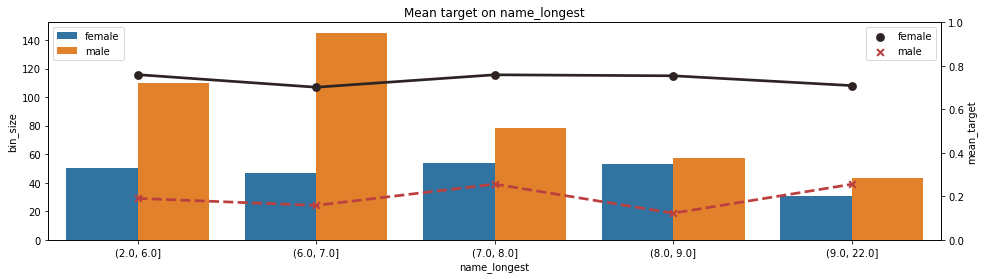

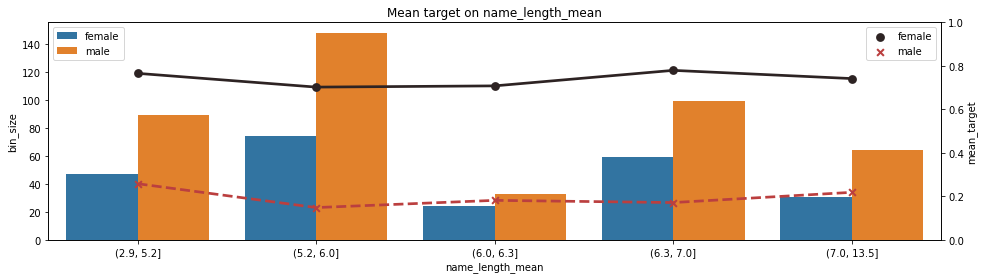

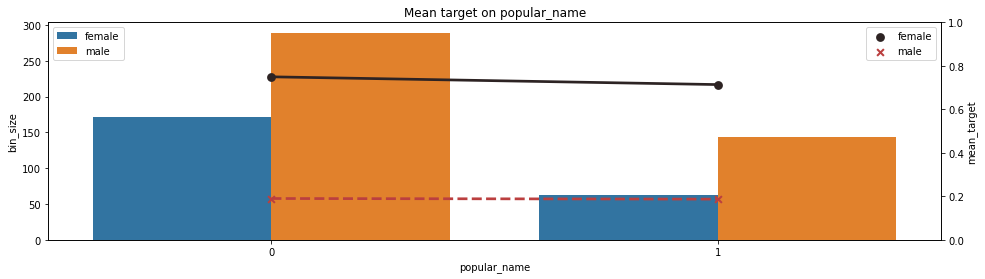

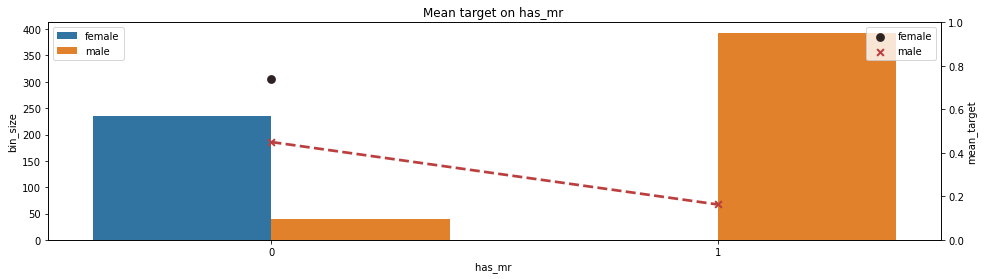

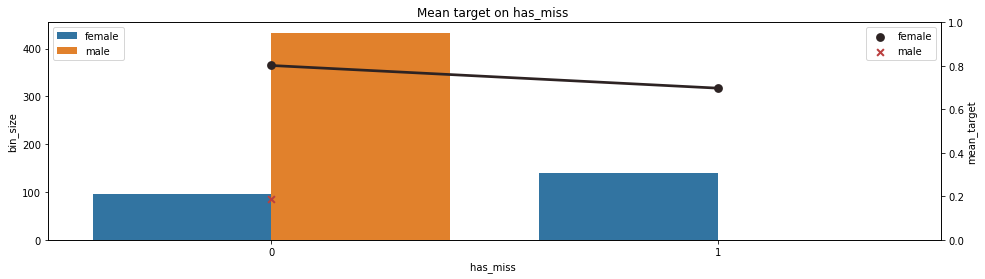

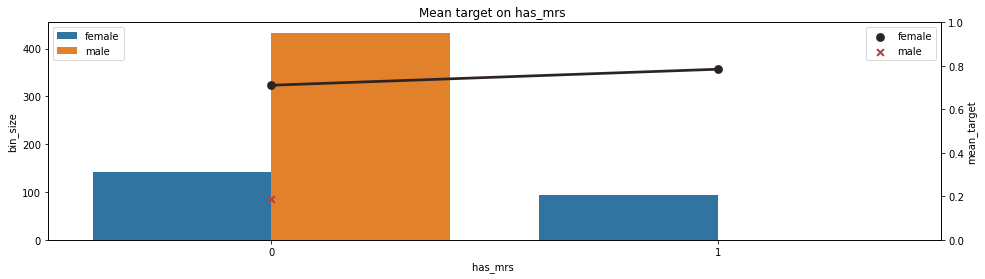

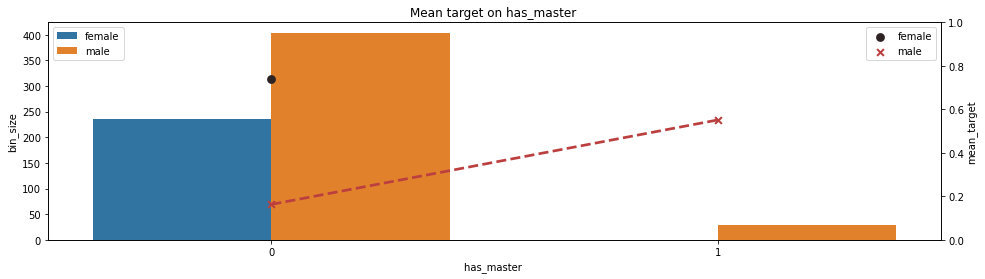

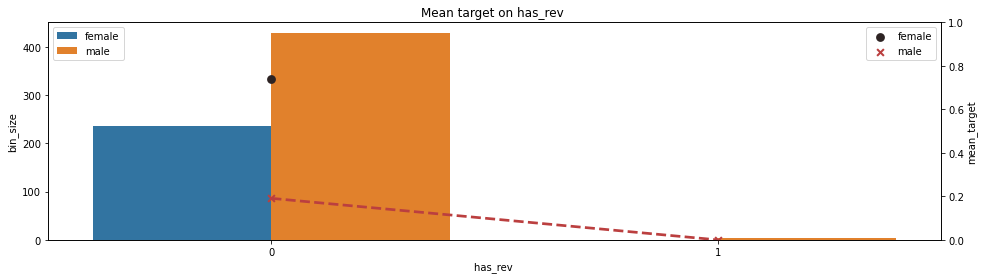

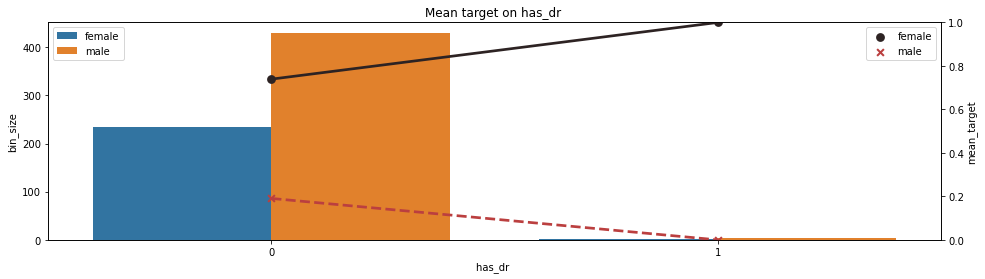

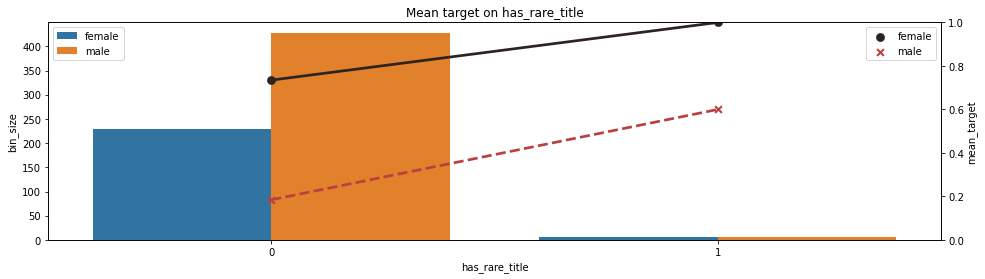

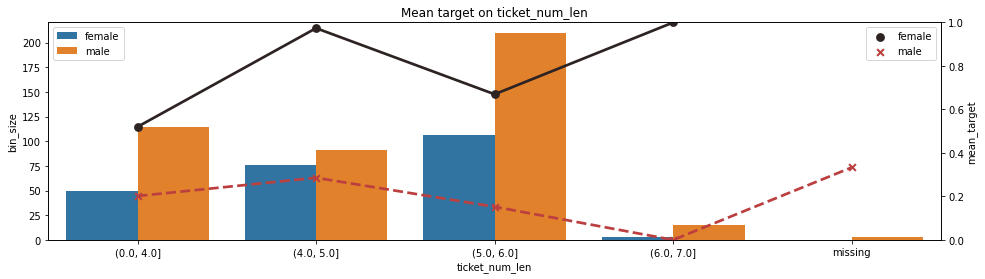

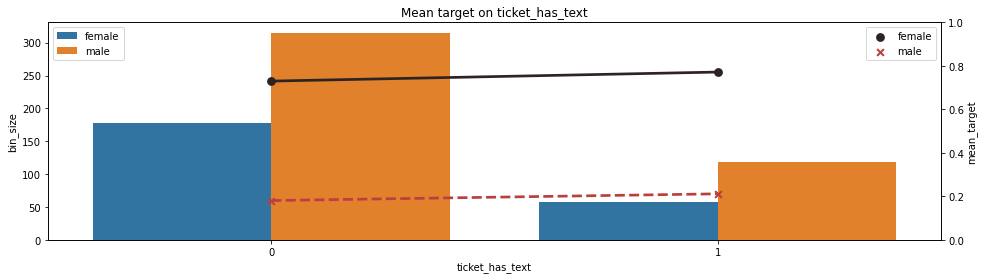

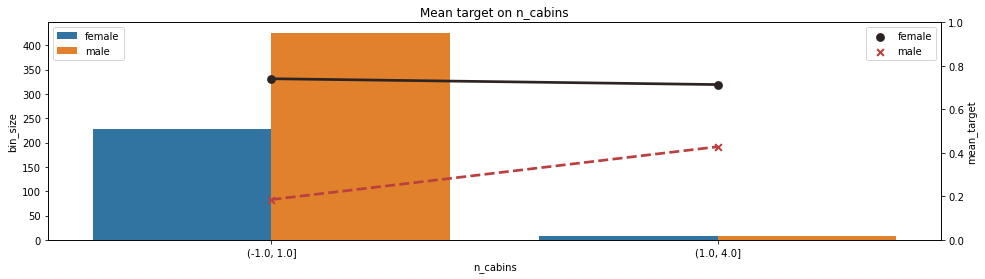

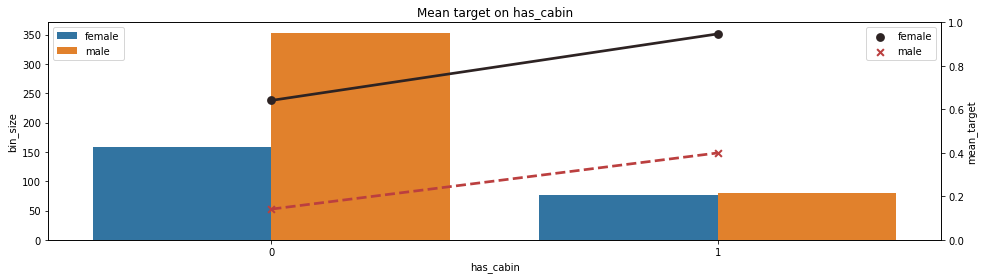

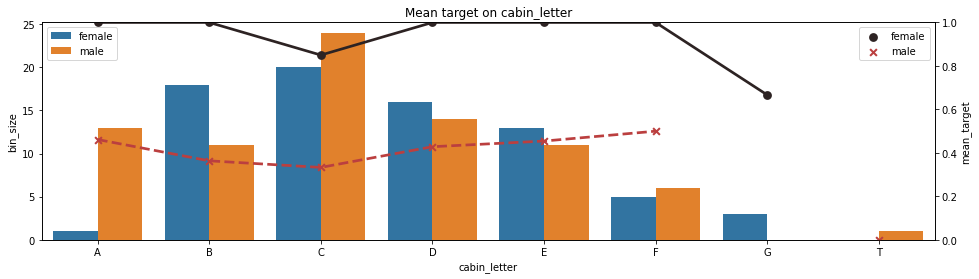

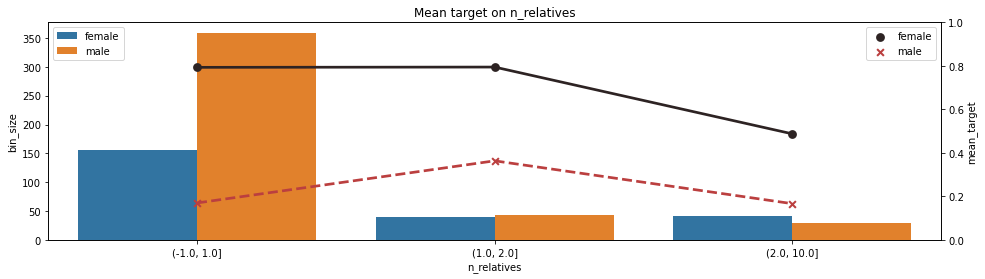

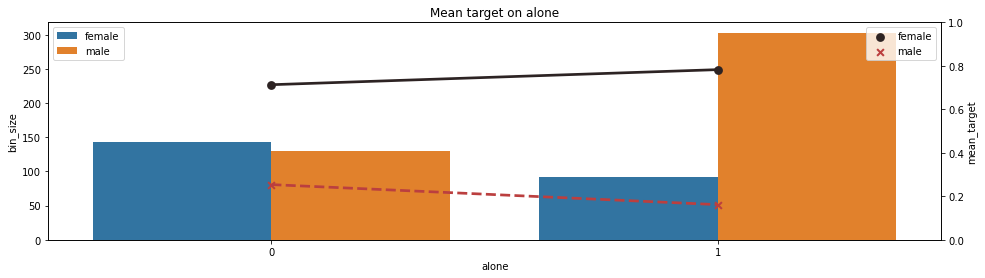

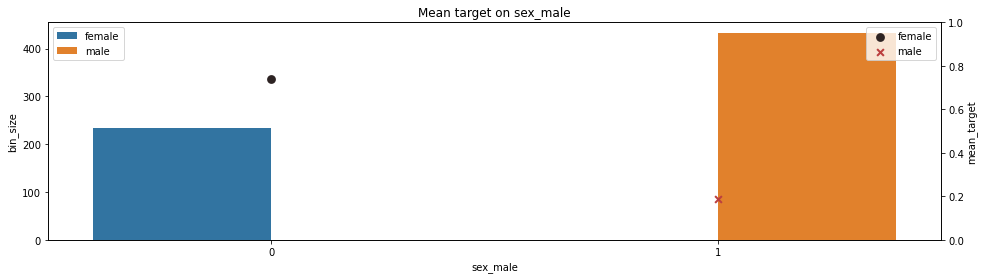

In [16]:
all_gen_str_feat = name_features + ticket_cab_feats + addit_feats

for variable in all_gen_str_feat:
    utils.eda.plot_target_bins(df_train_tr, variable, 'target')

Некоторые переменные явно имеют предсказательную силу

# Final preprocessing

Дальнейшая подготовка данных (пропущенные/категориальные) будет проходит внутри пайплайнов.

Также в связи с ограничением по времени я не буду комбинировать предикторы

Итого, на основе полученных функций, создадим sklearn совместимый трансформер  
Я размещу его в titanic_feature_generator.py

NOTE! <br/> 
Внутри трансформера мы отбрасываем переменные ['name', 'ticket', 'cabin', 'sex']  
С них мы уже сгенерировали предикторы  
('sex' заменил на бинарный 'sex_male')

## Check correlation

Импортируем наш трансформер на основе полученных ранеее функций

In [17]:
from utils.titanic_feature_generator import Titanic_Feature_Generator

In [18]:
feat_get = Titanic_Feature_Generator()

# сразу трансформируем весь треин сет
X_train_tr = feat_get.fit_transform(X_train, y_train)

In [19]:
def find_corr_cols(df, corr_thresh=0.7):
    """make corr matrix and find variable pairs with high correlation
    """
    # get corr array
    df_corr = df.corr(method='spearman')
    # fill diag with zeros
    df_corr.values[tuple([np.arange(df_corr.shape[0])]*2)] = 0
    
    # find correlated pairs
    corr_cols = set()
    for ind in np.argwhere(np.abs(df_corr.values) > corr_thresh):
        corr_coeff = np.abs(np.round(df_corr.values[ind[0], ind[1]], 5))
        corr_cols.add(frozenset([df_corr.columns[ind[0]], df_corr.columns[ind[1]], corr_coeff]))
    # Crutch to put corr_coeff first
    corr_cols = [int_first(item) for item in corr_cols]
    corr_cols = pd.DataFrame(corr_cols, columns=['corr', 'col_1', 'col_2']).sort_values('corr',
                                                                                       ascending=False)
    return corr_cols
    
def int_first(slist):
    """Crutch - insert int first"""
    nlist = []
    for item in slist:
        if isinstance(item, float):
            nlist.insert(0, item)
        else:
            nlist.append(item)
    return nlist

In [20]:
find_corr_cols(X_train_tr)

,corr,col_1,col_2
0,0.99710,n_cabins,has_cabin
8,0.96065,n_relatives,alone
2,0.88068,has_mr,sex_male
7,0.88012,name_size,name_length
6,0.85206,sibsp,n_relatives
1,0.83218,sibsp,alone
3,0.79900,parch,n_relatives
9,0.73445,name_length_mean,name_longest
5,0.71264,pclass,has_cabin
4,0.70708,pclass,n_cabins


Я отброшу переменные n_cabins и n_relatives. Их бинарных альтернатив будет достаточно

In [21]:
high_corr_cols = ['n_cabins', 'n_relatives']